# Backpack Prediction Challenge 2025
[Competition website](https://www.kaggle.com/competitions/playground-series-s5e2/overview)

Author:  Arnaud Dalbec-Constant

### Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
#from xgboost import XGBRegressor, plot_importance
#from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor, Pool
SEED = 1
warnings.filterwarnings("ignore")
#sns.set(style="whitegrid")

### Data exploration

In [2]:
# Load the Data
train_df = pd.read_csv("data/training_extra.csv").drop(columns=["id"],axis=1)
test_df = pd.read_csv("data/test.csv").drop("id",axis=1)
sample_submission = pd.read_csv("data/sample_submission.csv")

In [3]:
def data_exploration(df):
    print("DataFrame info")
    print("--------------------------")
    print(df.info())
    print("\n")  
    print("DataFrame head")
    print("--------------------------")
    print(df.head().T)
    print("\n")
    print("Data description")
    print("--------------------------")
    print(df.describe(include="all").T)
    print("\n")
    print("Number of Duplicated Rows:")
    print("--------------------------")
    print(df.duplicated().sum())
    print("\n")
    print("Number of Unique Values:")
    print("------------------------")
    print(df.nunique())
    print("\n")
    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    
data_exploration(train_df)

DataFrame info
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(3), object(7)
memory usage: 281.9+ MB
None


DataFrame head
--------------------------
                                 0          1          2          3          4
Brand                 Under Armour       Puma   Jansport       Nike       Nike
Material                    Canvas  Polyester  Polyester      Nylon    Leather
Size                         Small      Small      Small      Large      Large
Compar

### Observations

The data contains 9 features, 1 numeric (float64) and 8 descriptives with 2 of those being binary and 1 using numerical categorical values. 
We want to predict the price of the backpacks which is a numerical float64 value.

Let's explore how to handle the missing values

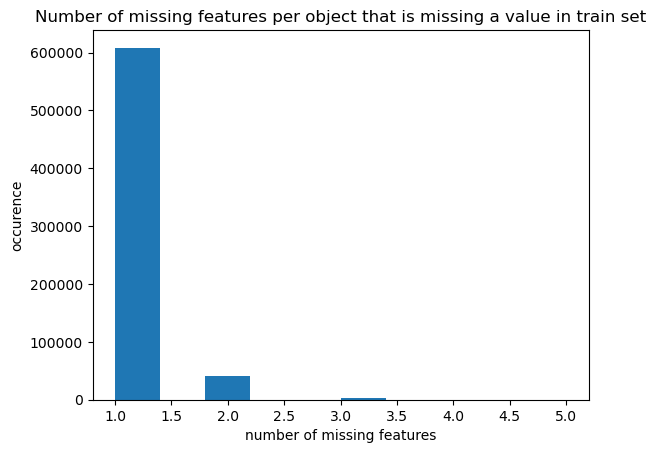

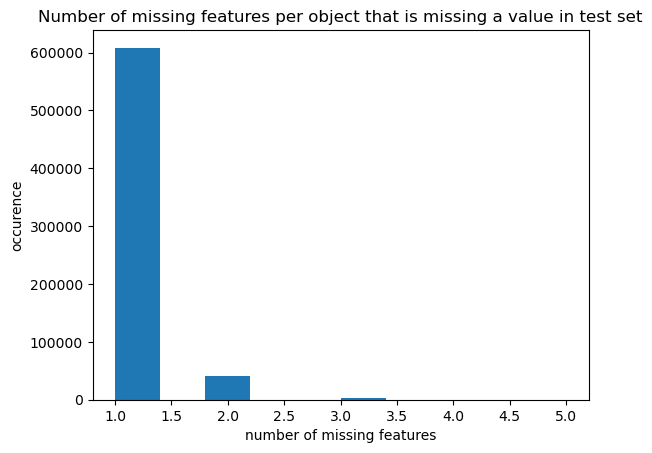

In [4]:
# How many rows contain some missing information
missing_value_per_id = train_df.isnull().sum(axis=1)

# Filter rows where any value is missing
missing_value_per_id = missing_value_per_id[missing_value_per_id > 0]

# Plot the histogram
plt.hist(missing_value_per_id)
plt.title('Number of missing features per object that is missing a value in train set')
plt.xlabel('number of missing features')
plt.ylabel('occurence')
plt.show()
# Does the test df contain missing features?
missing_value_per_id_test = test_df.isnull().sum(axis=1)

# Filter rows where any value is missing
missing_value_per_id_test = missing_value_per_id[missing_value_per_id > 0]

# Plot the histogram
plt.hist(missing_value_per_id_test)
plt.title('Number of missing features per object that is missing a value in test set')
plt.xlabel('number of missing features')
plt.ylabel('occurence')
plt.show()

The histogram shows that in most cases of a missing information, there is only one missing feature. Therefore most information is available and the prediction model should be trained with missing features. The model should take this into consideration, especially since more than 600,000 rows are missing information over the total 3,694,318 entries in the train set.

In [5]:
# Lets identify the numerical and categorical columns
categorical_columns = [
    'Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color'
]

numerical_columns = ['Compartments', 'Weight Capacity (kg)', 'Price']


### Exploring data distribution to identify under or over sampled sub categories.

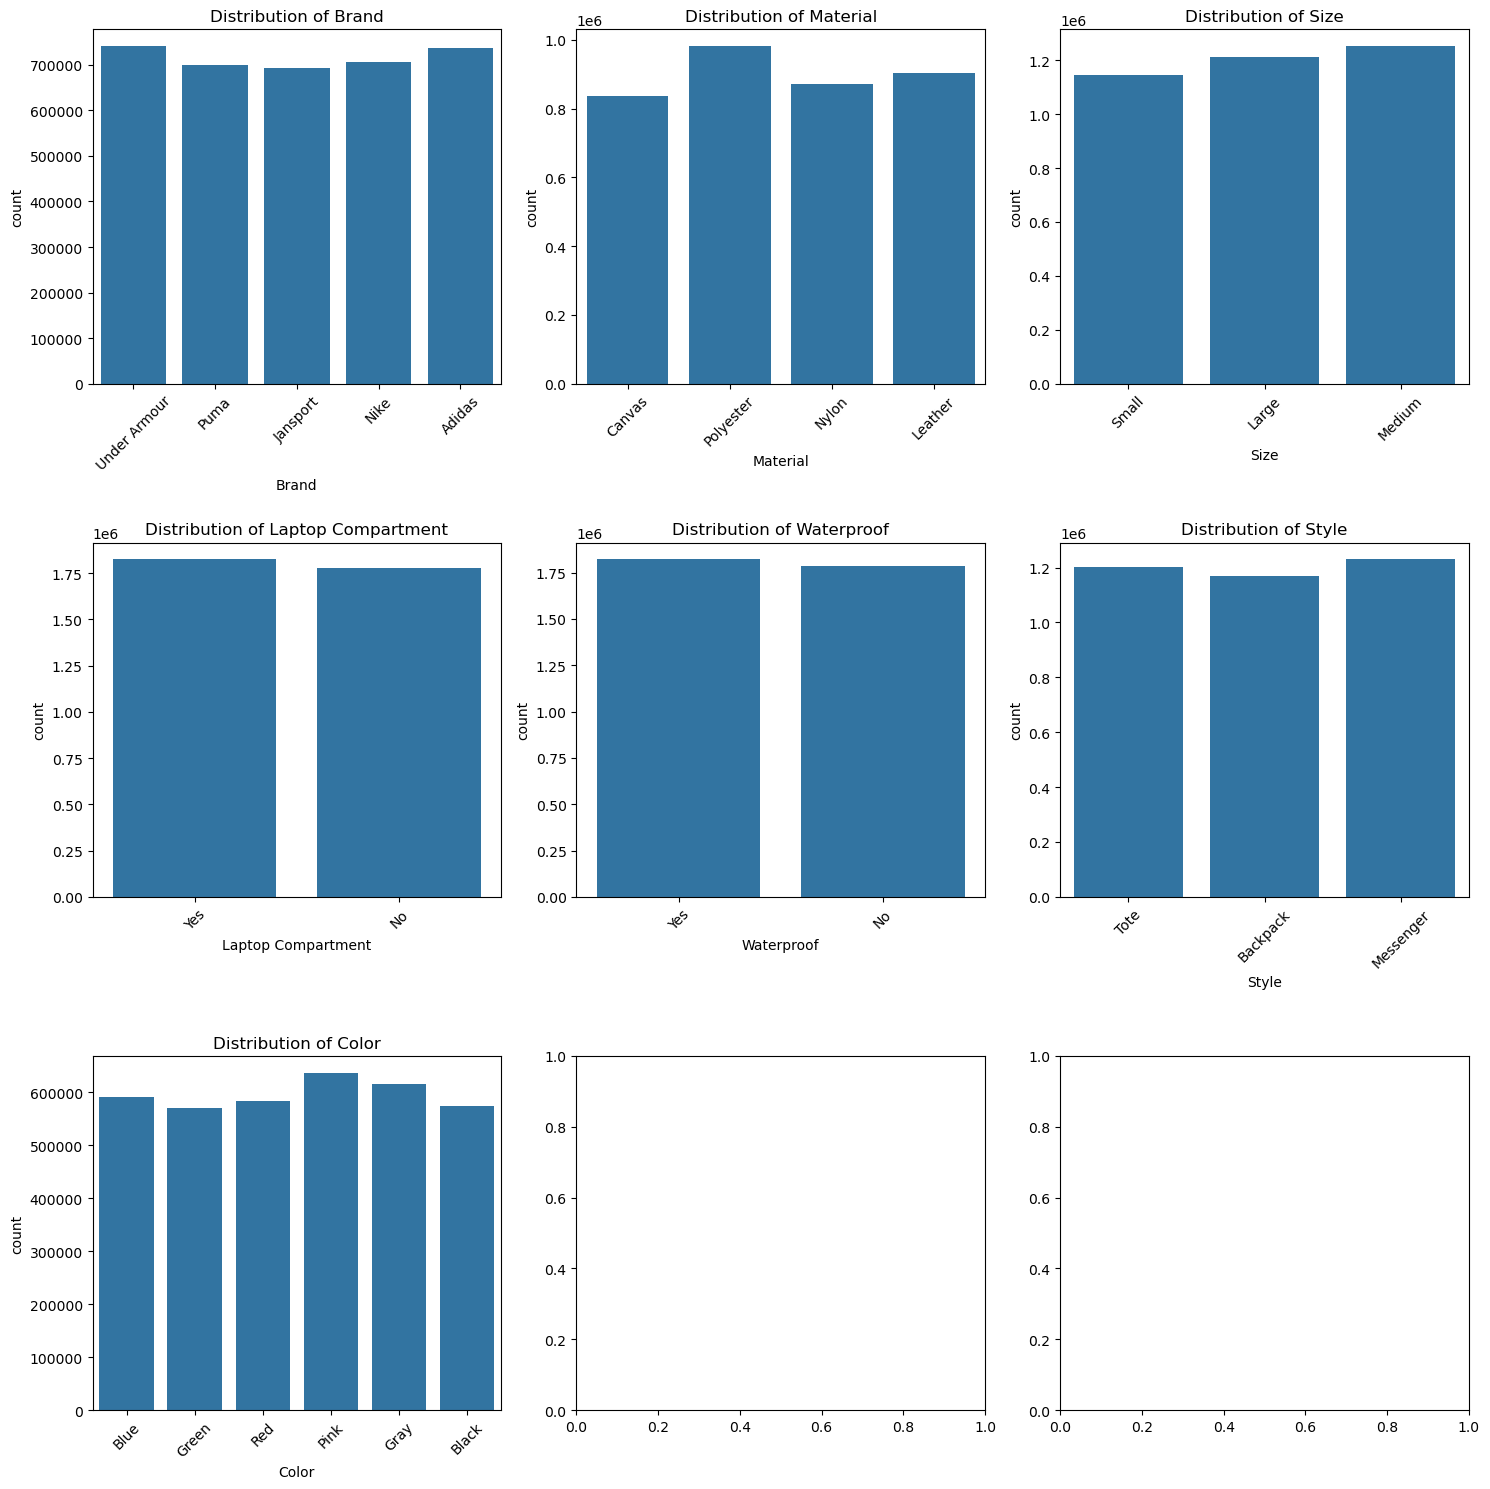

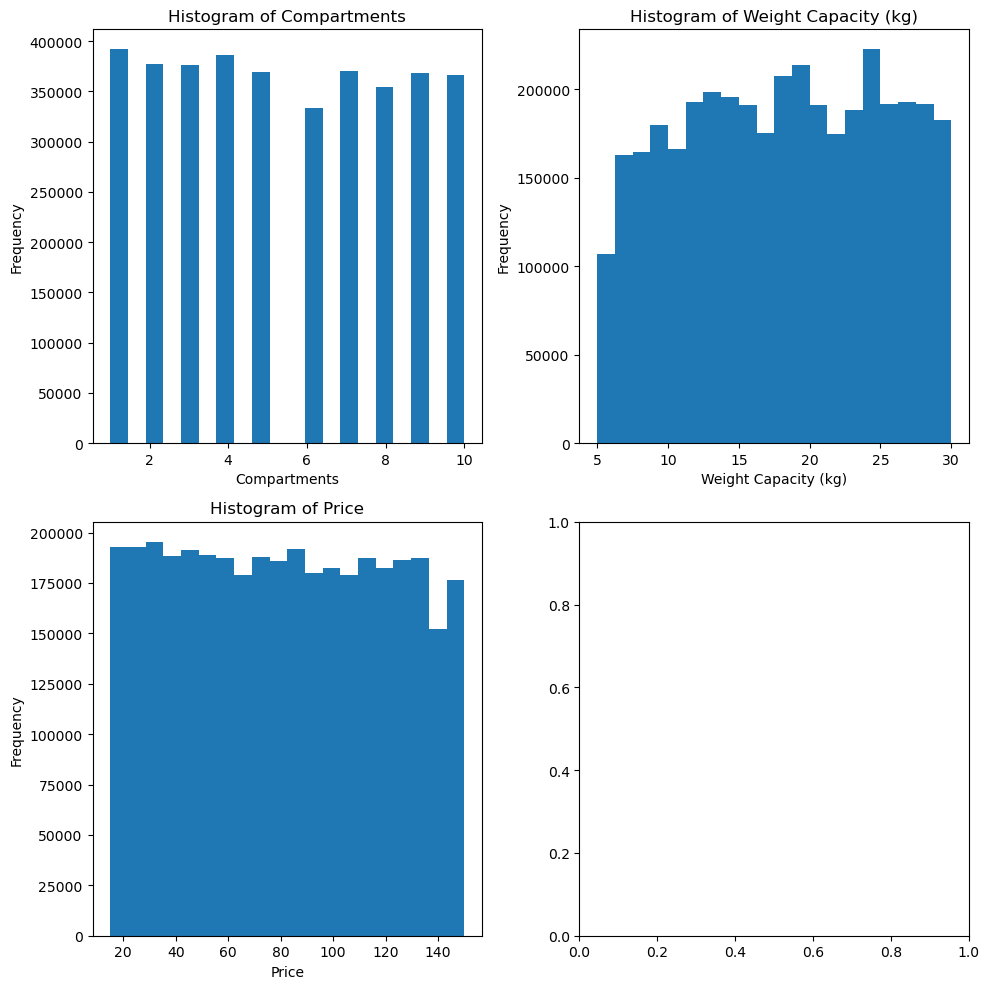

In [6]:
# Number of rows and columns in the grid (adjust based on the number of categorical columns)
num_rows_cat = len(categorical_columns) // 3 + 1  # 3 columns per row
fig, axes = plt.subplots(num_rows_cat, 3, figsize=(15, 5 * num_rows_cat))

# Plot the categorical column distributions in a grid
for i, col in enumerate(categorical_columns):
    row = i // 3
    col_idx = i % 3
    sns.countplot(x=col, data=train_df, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f"Distribution of {col}")
    axes[row, col_idx].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



# Number of rows and columns in the grid (adjust based on the number of numerical columns)
num_rows_num = len(numerical_columns) // 2 + 1  # 2 columns per row
fig, axes = plt.subplots(num_rows_num, 2, figsize=(10, 5 * num_rows_num))

# Plot the numerical column distributions (histograms) in a grid
for i, col in enumerate(numerical_columns):
    row = i // 2
    col_idx = i % 2
    train_df[col].plot(kind='hist', bins=20, ax=axes[row, col_idx], title=f"Histogram of {col}")
    axes[row, col_idx].set_xlabel(col)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

The bar charts above show that the data is well distributed over most categories. The only potential inbalance is in the lighter backpack category, but this will we fixed by applying weights in the pre-processing stage.

In [7]:
# Preprocessing
# -- Encoding --
# Size and compartments have natural orders, therefore they are going to be encoded with a numerical label
# Other Categorical features will be One-Hot Encoded

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

encoded_train_df = train_df
encoded_test_df = test_df

label_encoder = LabelEncoder()

encoded_train_df['Size'] = label_encoder.fit_transform(encoded_train_df['Size'])
encoded_test_df['Size'] = label_encoder.fit_transform(encoded_test_df['Size'])

categorical_cols = [ 
    'Brand', 'Material', 'Laptop Compartment', 'Waterproof', 'Style', 'Color'
]

# One hot encoding with fillna(0)
encoded_train_df = pd.get_dummies(encoded_train_df, columns=categorical_cols, drop_first=True).fillna(0).astype(int) # fill NA with a 0
# One hot encoding with dropna() in training
#encoded_train_df = pd.get_dummies(encoded_train_df, columns=categorical_cols, drop_first=True).dropna().astype(int) # fill NA with a 0

encoded_test_df = pd.get_dummies(encoded_test_df, columns=categorical_cols, drop_first=True).fillna(0).astype(int) # fill NA with a 0

# -- MinMax scaling --
numerical_cols = [
    'Compartments', 'Weight Capacity (kg)', 'Size'
]

scaler = MinMaxScaler()
encoded_train_df[numerical_cols] = scaler.fit_transform(encoded_train_df[numerical_cols])
encoded_test_df[numerical_cols] = scaler.fit_transform(encoded_test_df[numerical_cols])

x_train_df = encoded_train_df.drop(columns=['Price'])
y_train_df = encoded_train_df['Price']
x_test_df = encoded_test_df 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split in train and validation set
X_train, X_val, y_train, y_val = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42)

In [9]:
# Create submission file function
def create_submission(file_name, model_object):
    submission_df = pd.DataFrame(columns=['id','Price'])
    submission_df['id'] = pd.read_csv("data/test.csv")['id']

    # Linear regression model
    submission_df['Price'] = model_object.predict(x_test_df)
    submission_df.to_csv(file_name, index=False)
    print('file generated')
    print(submission_df.head())

In [10]:

from sklearn.linear_model import LinearRegression

# Linear regression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 1515.6680081169357
Root Mean Squared Error (RMSE): 38.931581115039954


In [11]:
create_submission('my_submission_file.csv', linear_regression)

file generated
       id      Price
0  300000  80.783290
1  300001  81.712866
2  300002  80.556052
3  300003  80.833476
4  300004  78.638488


With fillna(0)  
Mean Squared Error (MSE): 1515.6680081169354  
Root Mean Squared Error (RMSE): 38.931581115039954

Scores for dropna()  
Mean Squared Error (MSE): 1515.791161314405  
Root Mean Squared Error (RMSE): 38.93316274481698

In [12]:
"""
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
"""

'\nfrom sklearn.ensemble import RandomForestRegressor\n\n# Random Forest Regressor\nmodel = RandomForestRegressor(n_estimators=100, random_state=42)\nmodel.fit(X_train, y_train)\n\ny_pred = model.predict(X_val)\nmse = mean_squared_error(y_val, y_pred)\nrmse = np.sqrt(mse)\n\nprint(f"Mean Squared Error (MSE): {mse}")\nprint(f"Root Mean Squared Error (RMSE): {rmse}")\n'

Mean Squared Error (MSE): 1958.4132834545308  
Root Mean Squared Error (RMSE): 44.253963477348904

In [13]:
"""
# Random Forest Regressor
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
"""

'\n# Random Forest Regressor\nmodel = RandomForestRegressor(n_estimators=10, random_state=42)\nmodel.fit(X_train, y_train)\n\ny_pred = model.predict(X_val)\nmse = mean_squared_error(y_val, y_pred)\nrmse = np.sqrt(mse)\n\nprint(f"Mean Squared Error (MSE): {mse}")\nprint(f"Root Mean Squared Error (RMSE): {rmse}")\n'

Mean Squared Error (MSE): 1958.4132834545308    
Root Mean Squared Error (RMSE): 44.253963477348904

In [14]:
"""
from tensorflow import keras

# Define the neural network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(32, activation='relu'),  # Hidden layer
    #keras.layers.Dense(8, activation='relu'),  # Hidden layer
    keras.layers.Dense(1)  # Output layer (1 neuron for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Watch validation loss
    patience=3,          # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model weights
)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Predict
y_pred = model.predict(X_val)

# Calculate RMSE
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
"""

'\nfrom tensorflow import keras\n\n# Define the neural network\nmodel = keras.Sequential([\n    keras.layers.Dense(64, activation=\'relu\', input_shape=(X_train.shape[1],)),  # Input layer\n    keras.layers.Dense(32, activation=\'relu\'),  # Hidden layer\n    #keras.layers.Dense(8, activation=\'relu\'),  # Hidden layer\n    keras.layers.Dense(1)  # Output layer (1 neuron for regression)\n])\n\n# Compile the model\nmodel.compile(optimizer=\'adam\', loss=\'mse\')\n\n# Early stopping to prevent overfitting\nearly_stopping = keras.callbacks.EarlyStopping(\n    monitor=\'val_loss\',   # Watch validation loss\n    patience=3,          # Stop if no improvement after 10 epochs\n    restore_best_weights=True  # Restore the best model weights\n)\n\n# Train the model\nmodel.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)\n\n# Predict\ny_pred = model.predict(X_val)\n\n# Calculate RMSE\nmse = mean_squared_error(y_val, y_pred)\

Test results for different NN sizes with all data
|NN Structure | 64_32_1 | 128_64_1 | 32_16_1 | 32_16_8_1 | 64_32_16_1 |
|----------|----------|----------|----------|----------|----------|
|Mean Squared Error (MSE):  | 1515.578125   | 1516.796630859375   | 1516.632080078125   | 1516.25390625 | 1516.68701171875 |
|Root Mean Squared Error (RMSE):   | 38.9304267251208   | 38.94607336894664   | 38.94396076515748  | 38.93910510335336 | 38.944666023972395 |  

Test results for different NN sizes with with na drop
|NN Structure | 64_32_1 | 128_64_1 | 32_16_1 | 32_16_8_1 | 64_32_16_1 |
|----------|----------|----------|----------|----------|----------|
|Mean Squared Error (MSE):  | 1516.3536376953125   | 1515.912841796875   | 1515.89501953125   | 1517.371826171875 | 1515.7972412109375 |
|Root Mean Squared Error (RMSE):   | 38.94038569012013   | 38.934725397733   | 38.934496523407745  | 38.95345717868794 | 38.933240825943805|

In [15]:
#create_submission('my_submission_file_NN_64_32_1.csv', model)

In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.2,  # Step size shrinkage to prevent overfitting
    max_depth=6,  # Maximum depth of a tree
    subsample=0.8,  # Subsample ratio of training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    objective='reg:squarederror',  # Objective function for regression
    early_stopping_rounds=5  # Stop if validation loss doesn't improve
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    #eval_metric='rmse',
    #early_stopping_rounds=3,
    verbose=True
)

# Predict
y_pred = xgb_model.predict(X_val)

# Calculate RMSE
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

[0]	validation_0-rmse:38.94646
[1]	validation_0-rmse:38.93803
[2]	validation_0-rmse:38.93308
[3]	validation_0-rmse:38.92962
[4]	validation_0-rmse:38.92672
[5]	validation_0-rmse:38.92389
[6]	validation_0-rmse:38.92224
[7]	validation_0-rmse:38.92064
[8]	validation_0-rmse:38.91930
[9]	validation_0-rmse:38.91862
[10]	validation_0-rmse:38.91777
[11]	validation_0-rmse:38.91727
[12]	validation_0-rmse:38.91655
[13]	validation_0-rmse:38.91573
[14]	validation_0-rmse:38.91558
[15]	validation_0-rmse:38.91520
[16]	validation_0-rmse:38.91498
[17]	validation_0-rmse:38.91484
[18]	validation_0-rmse:38.91451
[19]	validation_0-rmse:38.91442
[20]	validation_0-rmse:38.91424
[21]	validation_0-rmse:38.91403
[22]	validation_0-rmse:38.91375
[23]	validation_0-rmse:38.91366
[24]	validation_0-rmse:38.91346
[25]	validation_0-rmse:38.91326
[26]	validation_0-rmse:38.91310
[27]	validation_0-rmse:38.91309
[28]	validation_0-rmse:38.91308
[29]	validation_0-rmse:38.91301
[30]	validation_0-rmse:38.91298
[31]	validation_0-

In [38]:
create_submission('my_submission_file_XGB_default4.csv', xgb_model)

file generated
       id      Price
0  300000  81.333145
1  300001  82.583710
2  300002  81.422836
3  300003  80.786461
4  300004  78.235878
